In [2]:
import pandas as pd
import numpy as np

In [3]:
from database.database_parser import create_connection
from database.database_parser import select_curr_solution

test_connection = create_connection('../database/abacus_database.db')

In [4]:
from database.database_parser import select_price_data

def generate_volatility(params, data):
    n_observations = len(data)
    initial_squared_vol_estimate = (params[0]
                                        + params[1] * (data[0] ** 2)
                                        + params[3] * (data[0] ** 2) * np.where(data[0] < 0, 1, 0)
                                        + params[2] * (data[0] ** 2))
    current_squared_vol_estimate = initial_squared_vol_estimate

    for i in range(0, n_observations):
        current_squared_vol_estimate = (params[0] + params[1] * (data[i - 1] ** 2)
                                            + params[3] * (data[i - 1] ** 2) * np.where(data[i - 1] < 0, 1, 0)
                                            + params[2] * current_squared_vol_estimate)

    return np.sqrt(current_squared_vol_estimate)

def get_volatility(asset: str):
    opt_sol = select_curr_solution(test_connection, asset)
    adj_close = select_price_data(test_connection, asset)
    log_returns = np.array(np.log(adj_close / adj_close.shift(1))[1:])
    return generate_volatility(params=opt_sol, data=log_returns)

In [5]:
from distributions.student_poisson_mixture import spm
# Calculate all inverse samples.
def generate_samples(us, asset):
    opt_sol = select_curr_solution(test_connection, asset)
    mu = opt_sol[4]
    sigma = get_volatility(asset)[0]
    kappa = opt_sol[5]
    lamb = opt_sol[6]
    nu = opt_sol[7]

    for p in us:
        s = spm.ppf(p, mu, sigma, kappa, lamb, nu)
        print(s.root)

In [29]:
u_sim = np.loadtxt('u_sim.txt', delimiter=',')
print(u_sim)

[[0.05806084 0.10830092 0.79261315 ... 0.28698886 0.21304408 0.06698927]
 [0.19199837 0.62810547 0.4585476  ... 0.49344329 0.57616201 0.60300312]
 [0.85327287 0.52715455 0.69477566 ... 0.63470831 0.69612464 0.29218895]
 ...
 [0.12185408 0.55500805 0.97048421 ... 0.10141121 0.0330822  0.05961305]
 [0.1097628  0.92412216 0.49309428 ... 0.63394547 0.30222343 0.50744772]
 [0.82957789 0.0398039  0.71617357 ... 0.63057063 0.8447574  0.66376797]]


In [33]:
generate_samples(u_sim[:, 4], 'HYG')

-0.02129814096861085
0.003363281439190654
-0.009168974202755163
0.132937656517599
-0.2848200304606345
-0.07400023424095362
-0.05762038410458104
0.07956052570507637
0.011785128685715442
1.0076536834687357
-0.060855226048366844
-0.03649883461918856
-0.2543930241216847
1.7202704232515815
0.07939045589499462
0.0013644893716073293
-0.020861869065917273
-0.035638441249102835
-0.08837352422491172
-0.03876602767288805
0.046894318857473825
-0.4178284041243213
-0.014551643536708589
0.9024194852956088
-0.006474033953872597
0.010249205266528321
0.6592572777975048
-0.1119649651648528
-0.007948298949174442
-0.08326819067847122
0.1014632548030031
-0.03270543016696243
0.018429788400436197
-0.2825827929380343
0.054369872001360224
0.05857211647085762
-0.011462758617087674
-0.04768655641159229
1.1668622096337957
-0.6242255395800783
0.017770826865670716
-0.8202489351633163
0.062417470983824254
0.023490234863310748
-0.023665963026429013
-0.01620301871827069
-0.03396966694662568
-0.02935539170090125
-0.0352

In [8]:
df_ret = pd.read_csv('../database/return_samples/1321.txt')
len(df_ret)

100

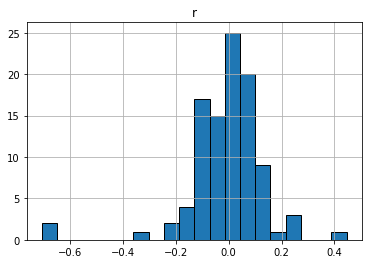

In [9]:
from matplotlib import pyplot as plt

df_ret.hist(bins=20, edgecolor='black')
plt.show()

In [28]:
from risk_utils.risk_utils import RiskAssessor

returns = df_ret['r'].to_list()
ra = RiskAssessor(np.array(returns))
ra.risk_summary()

======== RISK ASSESSMENT ========
VaR95 0.1469107408815382,    ES95 0.4237419251929184
VaR99 0.6540247122394408,     ES99 0.7055560561785977
EVT VaR99 0.6550702958355813, EVT ES99 0.6853100210384928


/Users/axelnilsson/Desktop/Abacus/risk_utils/risk_utils.py:131: RuntimeWarning: invalid value encountered in log
  log_likelihood = log_likelihood + np.log(1 + params[0] / params[1] * obs)
/Users/axelnilsson/Desktop/Abacus/risk_utils/risk_utils.py:133: RuntimeWarning: invalid value encountered in log
  return n_observations * np.log(params[1]) + (1 + 1 / params[0]) * log_likelihood
